In [33]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

We an advertisement company hired by the City of Chicago to create a series of safe driving Public Safety Anncouncements for young adults. 

These ads will run on social media as well as being posted near high schools and college campuses. 

In order to figure out what ads will be the most effective, we are examining the causes of accidents for two age ranges: 15-18 year olds and 18-22 year olds. Once we determine the most common causes of accidents, we will be able to tailor our ads for the city, and hopefully reduce accidents for our target group.

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

add results

# Data Import and Cleaning 

In [34]:
#df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
#df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
#df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [35]:
#Random sample of vehicles 
#df_accidents = df_vehicles.sample(n=300000, random_state=42)

In [36]:
#Then we can add the crash report data 
#df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [37]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
#df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [38]:
#df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [39]:
df_accidents = pd.read_csv("data/Final_Data.csv")

C:\Users\Owner\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [40]:
#Sets all column names to lowercase
df_accidents.columns = [column.lower() for column in df_accidents.columns]

# ^^^^^ DELETE BEFORE SUBMISSION

In [41]:
#have the crash date as a datetime object. 
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'], format="%m/%d/%Y %I:%M:%S %p")

df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324360 entries, 0 to 324359
Columns: 144 entries, unnamed: 0 to cell_phone_use
dtypes: datetime64[ns](1), float64(24), int64(9), object(110)
memory usage: 356.4+ MB


## Drop Unnessisary Columns

In [42]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

In [43]:
cols_to_drop = [
#remove unnessisary id columns now the data is joined 
'vehicle_id', 'crash_record_id', 'crash_unit_id',
#drop LAT and LONG (we have location)
'latitude', 'longitude',
#...also drop streets and directions. 
'street_no', 'street_direction', 'street_name', 'travel_direction', 
#police specific 
'beat_of_occurrence', 
#every data entry is in chicago 
'city', 'zipcode', 
#covered by MOST_SEVERE_INJURY
'injury_classification',
#many NAN
'injuries_unknown'
]

df_accidents.drop(columns=cols_to_drop, inplace=True)


In [44]:
#map the weather to a number 

def weather_code(weather):
    """
    Codes are based on https://openweathermap.org/weather-conditions
    0 - Unknown 
    500 - Rain
    600 - Snow
    700 - 'Atmosphere' (Fog, Dust, Haze) 
    800 - Clear
    801 - Clouds 

    """
    if weather == 'CLEAR':
        return 800
    elif weather == 'CLOUDY/OVERCAST':
        return 801
    elif weather == 'RAIN':
        return 500
    elif weather == 'SNOW' or weather == 'FREEZING RAIN/DRIZZLE' or weather== 'SLEET/HAIL' or weather == 'BLOWING SNOW':
        return 600
    elif weather == 'FOG/SMOKE/HAZE' or weather == 'BLOWING SAND/SOIL/DIRT':
        return 700
    else:
        return 0
    
df_accidents['weather_condition'] = df_accidents['weather_condition'].map(weather_code)

In [45]:
#map the injuries to a number 

def injury_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Indication of Injury 
    1 - REPORTED, NOT EVIDENT 
    2 - NONincapacitating Injury 
    3 - incapacitating Injury 
    4 - Fatal Injury 
    """
    if severity == 'NO INDICATION OF INJURY':
        return 0
    elif severity == 'REPORTED, NOT EVIDENT':
        return 1
    elif severity == 'NONINCAPACITATING INJURY':
        return 2
    elif severity == 'INCAPACITATING INJURY':
        return 3
    elif severity == 'FATAL':
        return 4
    else:
        return 0
    

df_accidents['injury_class'] = df_accidents['most_severe_injury'].map(injury_severity)

In [46]:
#map the crash severity to a number 

def crash_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['crash_type'] = df_accidents['crash_type'].map(crash_severity)

In [47]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
'injuries_reported_not_evident', 'injuries_no_indication'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [48]:
matrix = df_accidents.corr()
print(matrix)

                    unnamed: 0   unit_no  vehicle_year  occupant_cnt  \
unnamed: 0            1.000000 -0.012469     -0.000996     -0.002465   
unit_no              -0.012469  1.000000     -0.007320      0.103042   
vehicle_year         -0.000996 -0.007320      1.000000     -0.004234   
occupant_cnt         -0.002465  0.103042     -0.004234      1.000000   
posted_speed_limit   -0.001253  0.073894     -0.000297      0.029766   
weather_condition     0.002892  0.030809     -0.001856      0.034301   
crash_type           -0.008700  0.061903     -0.005193      0.090895   
num_units            -0.043967  0.276457     -0.000940      0.016165   
injuries_total       -0.013566  0.112213     -0.003746      0.193060   
crash_hour            0.000913  0.040057      0.001082     -0.001259   
crash_day_of_week     0.001974  0.009996      0.001206      0.001301   
crash_month          -0.001005  0.007062     -0.003140     -0.001107   
age                  -0.000979  0.020860     -0.004818     -0.19

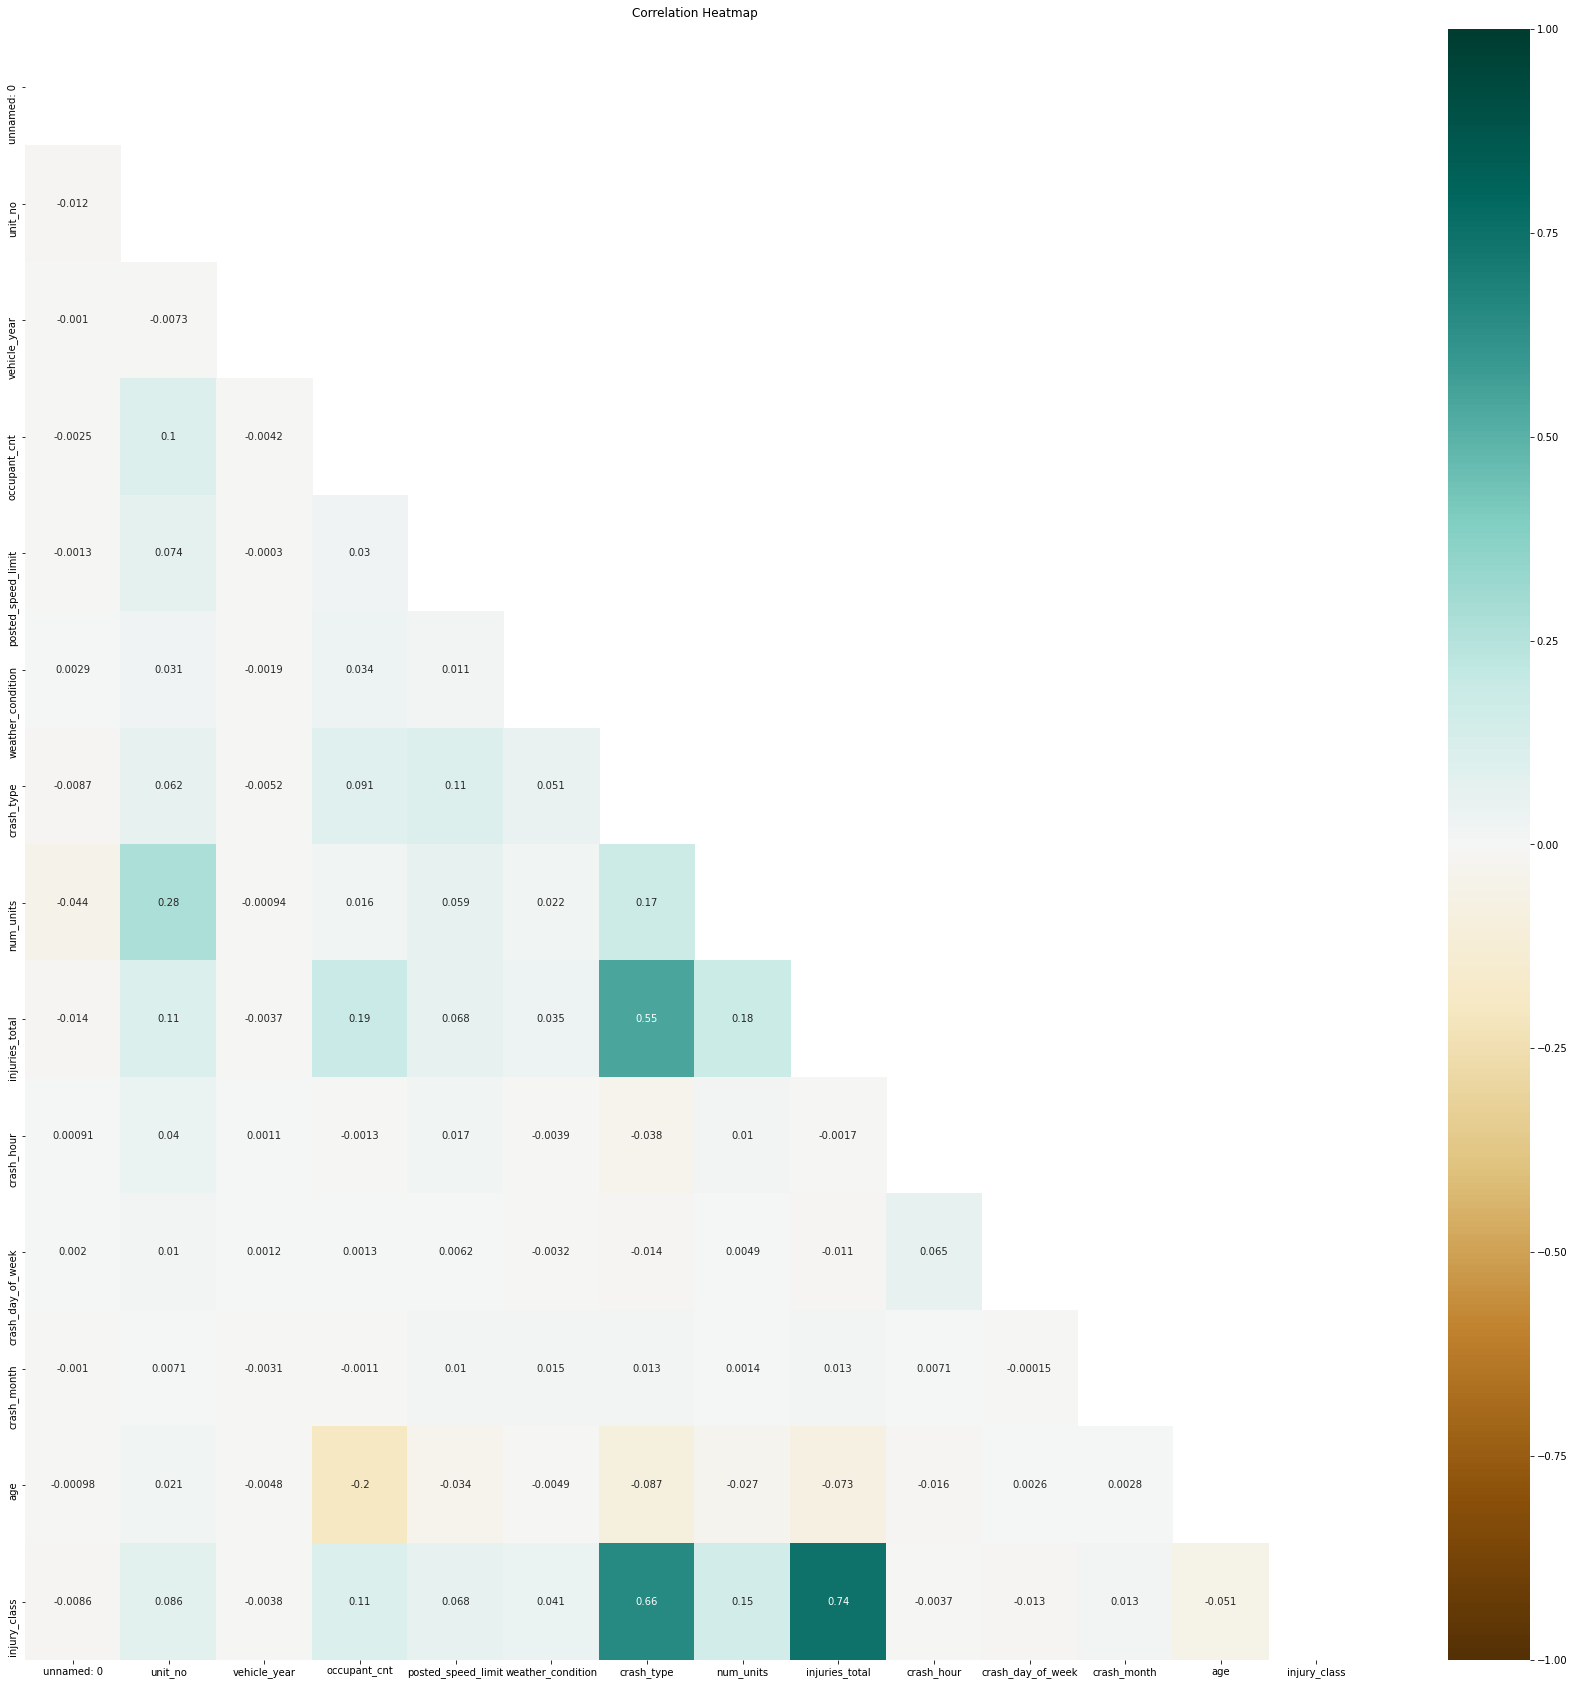

In [49]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [50]:
df_accidents['prim_contributory_cause'].unique()

array(['UNABLE TO DETERMINE', 'DISREGARDING TRAFFIC SIGNALS',
       'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY',
       'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING',
       'FAILING TO YIELD RIGHT-OF-WAY', 'WEATHER',
       'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
       'FAILING TO REDUCE SPEED TO AVOID CRASH', 'NOT APPLICABLE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'IMPROPER BACKING', 'DISTRACTION - FROM INSIDE VEHICLE',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'ROAD CONSTRUCTION/MAINTENANCE',
       'EXCEEDING AUTHORIZED SPEED LIMIT',
       'DISTRACTION - FROM OUTSIDE VEHICLE',
       'DRIVING ON WRONG SIDE/WRONG WAY',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'PHYSICAL CONDITION OF DRIVER', 'EQUIPMENT - VEHICLE CONDITION',
       'CELL PHONE USE OTHER THAN TEXTING', 'DISREGARDING ROAD MARKINGS',
       'ANIMAL', 'VISION OBSCURED 

In [51]:
# Categorize primary contributory cause into different categories

def bin_cause(cause):
    
    if cause == 'UNABLE TO DETERMINE':
        return 'UNABLE TO DETERMINE'
    
    elif cause in ['DISREGARDING TRAFFIC SIGNALS', 'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY', 
                   'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO YIELD RIGHT-OF-WAY',
                   'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
                   'FAILING TO REDUCE SPEED TO AVOID CRASH', 
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
                   'IMPROPER BACKING', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
                   'EXCEEDING AUTHORIZED SPEED LIMIT', 'DRIVING ON WRONG SIDE/WRONG WAY',
                   'DISREGARDING ROAD MARKINGS', 'EXCEEDING SAFE SPEED FOR CONDITIONS', 'DISREGARDING YIELD SIGN',
                   'TURNING RIGHT ON RED', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'PASSING STOPPED SCHOOL BUS',
                   'RELATED TO BUS STOP', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']:
        return 'ROAD SAFETY IGNORANCE'
                 
    elif cause in ['UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)']:
        return 'DRUNK/IMPAIRED DRIVING'
    
    elif cause in ['DISTRACTION - FROM INSIDE VEHICLE', 'DISTRACTION - FROM OUTSIDE VEHICLE', 
                   'CELL PHONE USE OTHER THAN TEXTING', 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
                   'TEXTING']:
        return 'DISTRACTED'     
    
 #we may want to look into NOT APPLICABLE to see what that could mean                
    elif cause in ['NOT APPLICABLE', 'PHYSICAL CONDITION OF DRIVER', 
                 'EQUIPMENT - VEHICLE CONDITION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
                 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
                 'OBSTRUCTED CROSSWALKS', 'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER', 'ANIMAL']:
        return 'NO FAULT OF DRIVER'
    
df_accidents['prim_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
    

In [55]:
df_accidents['prim_contributory_cause'].value_counts()

ROAD SAFETY IGNORANCE     11090
UNABLE TO DETERMINE        5299
NO FAULT OF DRIVER         1440
DISTRACTED                  313
DRUNK/IMPAIRED DRIVING       80
Name: prim_contributory_cause, dtype: int64

In [53]:
df_accidents = df_accidents.loc[(df_accidents['age'] > 14) & (df_accidents['age'] < 23) & (df_accidents['person_type'] == 'DRIVER')]
df_accidents

,unnamed: 0,crash_date,unit_no,unit_type,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,...,age,drivers_license_state,safety_equipment,airbag_deployed,ejection,driver_action,driver_vision,physical_condition,bac_result,injury_class
44,44,2020-08-15 21:00:00,2,DRIVER,VOLKSWAGEN,JETTA,IL,2014.0,NONE,PASSENGER,...,21.0,IL,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0
48,48,2018-04-22 17:54:00,1,DRIVER,HYUNDAI,SONATA,IN,NaN,UNKNOWN,PASSENGER,...,21.0,IN,USAGE UNKNOWN,DID NOT DEPLOY,NONE,IMPROPER PASSING,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0
51,51,2017-11-14 14:30:00,1,DRIVER,"TOYOTA MOTOR COMPANY, LTD.",TOYOTA,IL,2006.0,UNKNOWN,PASSENGER,...,18.0,IL,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0
72,72,2018-09-23 08:00:00,2,DRIVER,DODGE,CHARGER,IL,2013.0,NONE,PASSENGER,...,19.0,IL,USAGE UNKNOWN,DID NOT DEPLOY,NONE,FOLLOWED TOO CLOSELY,UNKNOWN,NORMAL,TEST NOT OFFERED,0
78,78,2022-10-01 13:59:00,2,DRIVER,FORD,FUSION,IL,2009.0,NONE,PASSENGER,...,21.0,NaN,USAGE UNKNOWN,"DEPLOYED, FRONT",NONE,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324299,324299,2016-10-01 23:45:00,1,DRIVER,PONTIAC,G6,IL,2007.0,NONE,PASSENGER,...,22.0,IL,USAGE UNKNOWN,DID NOT DEPLOY,NONE,FOLLOWED TOO CLOSELY,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0
324334,324334,2018-12-09 01:15:00,1,DRIVER,NISSAN,NISSAN MAXIMA,IL,2006.0,NONE,PASSENGER,...,21.0,NaN,SAFETY BELT USED,"DEPLOYED, FRONT",NONE,OTHER,NOT OBSCURED,FATIGUED/ASLEEP,TEST NOT OFFERED,2
324345,324345,2015-11-13 06:24:00,1,DRIVER,VOLKSWAGEN,JETTA,IL,2006.0,NONE,PASSENGER,...,22.0,IL,SAFETY BELT USED,DID NOT DEPLOY,NONE,FOLLOWED TOO CLOSELY,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0
324350,324350,2024-01-03 12:45:00,1,DRIVER,JEEP,COMPASS,IL,2014.0,UNKNOWN,PASSENGER,...,19.0,NaN,USAGE UNKNOWN,DID NOT DEPLOY,UNKNOWN,OTHER,UNKNOWN,NORMAL,TEST NOT OFFERED,0


# Decision Tree

In [54]:
#Train-Test Split

X = df_accidents.select_dtypes(exclude=['object'])
X = X.drop(columns='prim_contributory_cause') #bug found with categorized data not being a number
X = X.drop(columns=['unnamed: 0', 'crash_date', 'unit_no', 'num_units', 'injuries_total', 'injury_class'])
y = df_accidents['prim_contributory_cause']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2)

,unnamed: 0,crash_date,unit_no,vehicle_year,occupant_cnt,posted_speed_limit,weather_condition,crash_type,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,age,injury_class
44,44,2020-08-15 21:00:00,2,2014.0,2.0,30,800,0,2,0.0,21,7,8,21.0,0
48,48,2018-04-22 17:54:00,1,NaN,1.0,30,800,0,2,0.0,17,1,4,21.0,0
51,51,2017-11-14 14:30:00,1,2006.0,1.0,35,800,1,2,0.0,14,3,11,18.0,0
72,72,2018-09-23 08:00:00,2,2013.0,1.0,35,800,1,3,0.0,8,1,9,19.0,0
78,78,2022-10-01 13:59:00,2,2009.0,3.0,30,800,1,3,4.0,13,7,10,21.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324299,324299,2016-10-01 23:45:00,1,2007.0,2.0,30,801,0,2,0.0,23,7,10,22.0,0
324334,324334,2018-12-09 01:15:00,1,2006.0,1.0,30,800,1,1,1.0,1,1,12,21.0,2
324345,324345,2015-11-13 06:24:00,1,2006.0,2.0,30,800,1,2,0.0,6,6,11,22.0,0
324350,324350,2024-01-03 12:45:00,1,2014.0,2.0,30,800,0,3,0.0,12,4,1,19.0,0


In [29]:
#examine data balance 
y.value_counts()

NameError: name 'y' is not defined

In [325]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [326]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.9593756225276758
Testing: 0.3080263551961665


## Combine Columns into Categories 

In [17]:
#py

## Train Test Split

# Model 1

Justification of Model 1

Conclusions from model 1.

# Model 2

Justification of Model 2

Conclusions from model 1.

# Conclusions 

# Next Steps

# Appendix

In [ ]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1